# scope traces - FFPR
used with csv files produced from Rigol scopes

In [161]:
import matplotlib.pyplot as plt
from numpy import *
from scipy.optimize import curve_fit
import csv
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
c = 2.998e8 # m/s

In [5]:
def process_csv(fname, newline='', cols=True, skiprows=1):
    rows = []
    with open(fname, 'r', newline=newline) as f:
        reader = csv.reader(f, delimiter=',')

        while skiprows > 0:
            reader.__next__()
            skiprows -= 1
        
        for row in reader:
            try:
                rows.append([float(x) for x in row if x != ''])
            except ValueError:
                print(f"row is problematic: \n {row}")

    if cols:
        return array(rows).T
    
    return rows

def norm_data(ypts, y0=0):
    """
    y0: if the 0 pt of the signal has a bias, set y0=bias
    """
    normed = ypts - y0
    normed /= max(normed)
    return normed

## Oct 2021

### 2021.10.22

In [171]:
# sample the file contents, get time increment

files = ['./20211022/'+f'NewFile{s}.csv' for s in list(range(1,7))]
fname = files[0]
newline=''
with open(fname, 'r', newline=newline) as f:
    reader = csv.reader(f, delimiter=',')
    for i,row in enumerate(reader):
        if i == 1:
            t_incr = float(row[2])        
        if i < 10:
            print(row)

['CH1', 'CH2', 'Start', 'Increment', '']
['Volt', 'Volt', '-6.00000e-05', '1.00000e-07']
['9.60e+01', '4.00e-04', '']
['9.60e+01', '3.20e-04', '']
['9.60e+01', '4.80e-04', '']
['9.60e+01', '4.80e-04', '']
['9.60e+01', '4.80e-04', '']
['9.60e+01', '3.20e-04', '']
['9.60e+01', '3.20e-04', '']
['9.60e+01', '5.60e-04', '']


In [172]:
data = [process_csv(f, skiprows=2) for f in files]
data

[array([[9.60e+01, 9.60e+01, 9.60e+01, ..., 9.92e+01, 9.92e+01, 9.92e+01],
        [4.00e-04, 3.20e-04, 4.80e-04, ..., 6.40e-04, 0.00e+00, 5.60e-04]]),
 array([[9.60e+01, 9.60e+01, 9.52e+01, ..., 1.00e+02, 1.00e+02, 1.00e+02],
        [4.00e-04, 5.60e-04, 3.20e-04, ..., 5.60e-04, 5.60e-04, 3.20e-04]]),
 array([[9.60e+01, 9.52e+01, 9.52e+01, ..., 1.00e+02, 9.92e+01, 9.92e+01],
        [4.80e-04, 8.00e-04, 6.40e-04, ..., 7.20e-04, 2.40e-04, 3.20e-04]]),
 array([[9.60e+01, 9.60e+01, 9.52e+01, ..., 1.00e+02, 1.01e+02, 1.01e+02],
        [6.40e-04, 5.60e-04, 3.20e-04, ..., 5.60e-04, 3.20e-04, 0.00e+00]]),
 array([[9.60e+01, 9.60e+01, 9.52e+01, ..., 1.00e+02, 1.00e+02, 1.00e+02],
        [6.40e-04, 4.00e-04, 4.00e-04, ..., 4.80e-04, 6.40e-04, 9.60e-04]]),
 array([[9.60e+01, 9.60e+01, 9.52e+01, ..., 1.00e+02, 1.00e+02, 1.00e+02],
        [4.80e-04, 4.00e-04, 7.20e-04, ..., 4.80e-04, 5.60e-04, 2.40e-04]])]

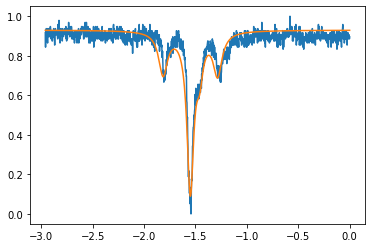

In [198]:
lor = lambda x,x0,g: ((1/pi)*(0.5*g))/((x-x0)**2+(0.5*g)**2)
def model(x,x0,fwhm1,fwhm2,a1,a2,a3,omega,b,dx):
    """birefringent cavity with sidebands"""
    return (b-a2*lor(x,x0-omega,fwhm2) #sideband
            -a2*lor(x,x0+omega,fwhm2) #sideband
            -a1*lor(x,x0,fwhm1) #carrier, H
            -a3*lor(x,x0+dx,fwhm1)) # carrier, V. V/H are arbitrary polarization labels.
norm_d = norm_data(data[0][1],min(data[0][1]))
plt.plot(tpts,norm_d)

# fit by eye
plt.plot(tpts,model(tpts,
                    x0=-1.55, # bounds [-2,1]
                    fwhm1=0.08, # bounds [0.01,.2]
                    fwhm2=0.104, # bounds [0.01,.2]
                    a1=0.1, # bounds [0.1,.4]
                    a2=0.035, # bounds [0.01,.05]
                    a3=0.022, # bounds [0.01,.05]
                    omega=.265, # bounds [0.1,1]
                    b=0.93, # bounds [0.7,1]
                    dx=0.09)) # bounds [0,0.5]
                

In [178]:
## plot and optionally fit to raw data

show_raw_data = True
show_smoothed_data = False
fit = False

idx0 = 10
idx1 = -10 # clip the endpts of the convolution
tpts_smth = tpts[idx0:idx1]

# known cavity length
l_cav = 1.1e-4
FSR = c/(2*l_cav)

for d in data:
    fig,ax = plt.subplots()
    ksize = 10
    kernel = ones(ksize)/ksize
    norm_d = norm_data(d[1],min(d[1]))
    
    if fit:
        popt, pcov = curve_fit(model,tpts,norm_d,
                               bounds=([-4,0.01,0.01,0.1,0.01,.01,0.1,0.7,0],
                                       [1,.2,.2,.4,.05,.05,1,1,0.05]))
        x0,fwhm1,fwhm2,a1,a2,a3,omega,b,dx = popt
    
        # time to frequency conversion using known eom freq.
        Hz_per_t = 2.975e6/(omega/1e3)

        # FWHM of cavity at carrier linewidth in Hz
        fwhm_cav = Hz_per_t*fwhm1

        # Finesse
        F = FSR/fwhm_cav
    
#     print(f"Finesse={F},linewidth={fwhm_cav/1e6}MHz (L_cav=110um)")
    
    if show_raw_data:
        ax.plot(tpts,norm_d,label='FFPR Reflection')
    if show_smoothed_data:
        smoothed_data = convolve(norm_d,kernel,mode='same')[idx0:idx1]
        ax.plot(tpts_smth,smoothed_data,'-',label='smoothed data')
    if fit:
        ax.plot(tpts,model(tpts,*popt),'--',label='fit')
        ax.set_title(f"Finesse={int(F)},linewidth={int(fwhm_cav/1e6)}MHz (L_cav=110um)")
    ax.legend()

array([-1.41209497,  0.08462607,  0.10473142,  0.1       ,  0.02282423,
        0.26595057,  0.93217534])

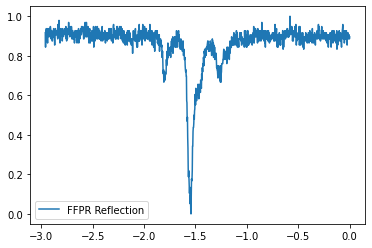

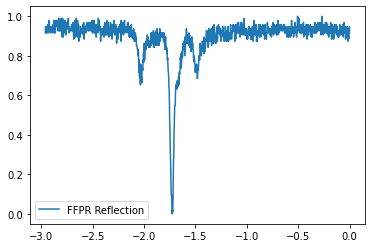

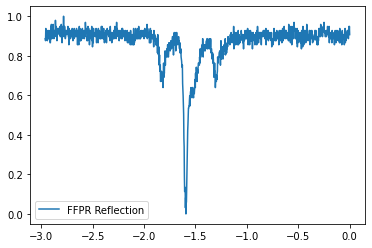

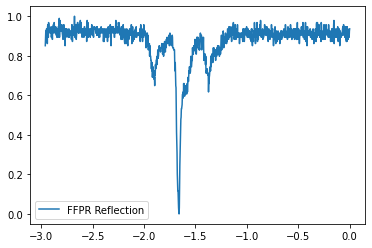

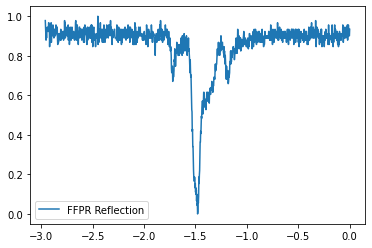

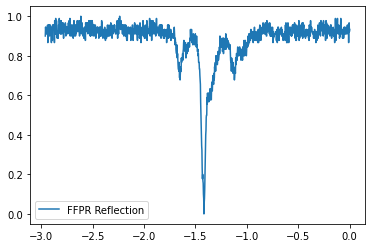

In [201]:
## plot and optionally fit to raw data

show_raw_data = True
show_smoothed_data = False
fit = False

idx0 = 10
idx1 = -10 # clip the endpts of the convolution
tpts_smth = tpts[idx0:idx1]

# known cavity length
l_cav = 1.1e-4
FSR = c/(2*l_cav)

for d in data:
    fig,ax = plt.subplots()
    ksize = 10
    kernel = ones(ksize)/ksize
    norm_d = norm_data(d[1],min(d[1]))
    
    if fit:
        popt, pcov = curve_fit(model,tpts,norm_d,
                               bounds=([-4,0.01,0.01,0.1,0.01,.01,0.1,0.7,0],
                                       [1,.2,.2,.4,.05,.05,1,1,0.05]))
        x0,fwhm1,fwhm2,a1,a2,a3,omega,b,dx = popt
    
        # time to frequency conversion using known eom freq.
        Hz_per_t = 2.975e6/(omega/1e3)

        # FWHM of cavity at carrier linewidth in Hz
        fwhm_cav = Hz_per_t*fwhm1

        # Finesse
        F = FSR/fwhm_cav
    
#     print(f"Finesse={F},linewidth={fwhm_cav/1e6}MHz (L_cav=110um)")
    
    if show_raw_data:
        ax.plot(tpts,norm_d,label='FFPR Reflection')
    if show_smoothed_data:
        smoothed_data = convolve(norm_d,kernel,mode='same')[idx0:idx1]
        ax.plot(tpts_smth,smoothed_data,'-',label='smoothed data')
    if fit:
        ax.plot(tpts,model(tpts,*popt),'--',label='fit')
        ax.set_title(f"Finesse={int(F)},linewidth={int(fwhm_cav/1e6)}MHz (L_cav=110um)")
    ax.legend()

### Ceci's data
after the last gluing step, while the assembly is still on the NanoMax

In [64]:
# sample the file contents, get time increment
files = ['ffpr_dips_ceci_data_after_gluing_20211014.csv']
fname = files[0]
newline=''
with open(fname, 'r', newline=newline) as f:
    reader = csv.reader(f, delimiter=',')
    for i,row in enumerate(reader):
#         if i == 1:
#             t_incr = float(row[2]) # this may throw an error if you saved > 2 channels
        if i < 10:
            print(row)

['5.403463528878930111e-01']
['5.397021305444806849e-01']
['5.400242417161636999e-01']
['5.409905752314903005e-01']
['5.400242417161636999e-01']
['5.400242417161636999e-01']
['5.406684640596686187e-01']
['5.403463528878930111e-01']
['5.409905752314903005e-01']
['5.400242417161636999e-01']


In [65]:
data = [process_csv(f, skiprows=2) for f in files]
data

[array([[0.54002424, 0.54099058, 0.54002424, ..., 0.53615891, 0.53615891,
         0.53648102]])]

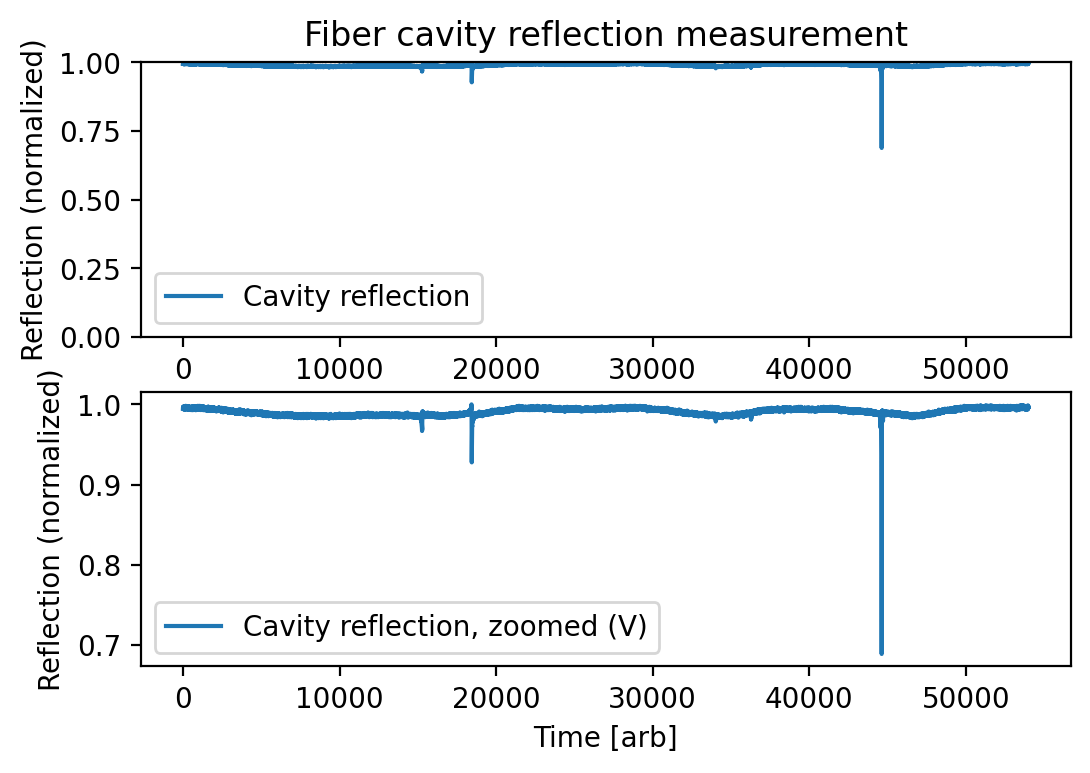

In [77]:
len(data[0][0])
norm_refl = data[0][0]/max(data[0][0])
fig,axes = plt.subplots(2,1,dpi=200)
ax,ax1 = axes
ax.set_title("Fiber cavity reflection measurement")
ax.plot(range(len(data[0][0][:54000])),norm_refl[:54000],label="Cavity reflection")
# ax.set_xlabel('Time [arb]')
ax.set_ylabel("Reflection (normalized)")
ax.set_ylim((0,1))
ax.legend()

# ax.set_title("Fiber cavity reflection measurement")
ax1.plot(range(len(data[0][0][:54000])),norm_refl[:54000],label="Cavity reflection, zoomed (V)")
ax1.set_xlabel('Time [arb]')
ax1.set_ylabel("Reflection (normalized)")
ax1.legend()
# ax1.set_ylim((0,1))


### my data
after installing the cavity in our system, still in air

In [54]:
# sample the file contents, get time increment
files = ['ffpr_ramp_and_dips_20211019.csv','ffpr_ramp_and_zero_20211019.csv']
fname = files[0]
newline=''
with open(fname, 'r', newline=newline) as f:
    reader = csv.reader(f, delimiter=',')
    for i,row in enumerate(reader):
        if i == 1:
            t_incr = float(row[2]) # this may throw an error if you saved > 2 channels
        if i < 10:
            print(row)

['CH1', 'CH2', 'Start', 'Increment', '']
['Volt', 'Volt', '-2.47000e-03', '5.00000e-06']
['2.24e+01', '8.48e-01', '']
['2.16e+01', '8.64e-01', '']
['2.24e+01', '8.48e-01', '']
['2.16e+01', '8.64e-01', '']
['2.24e+01', '8.48e-01', '']
['2.08e+01', '8.64e-01', '']
['2.08e+01', '8.48e-01', '']
['2.16e+01', '8.64e-01', '']


In [55]:
data = [process_csv(f, skiprows=2) for f in files]
data

[array([[ 22.4  ,  21.6  ,  22.4  , ..., 130.   , 130.   , 131.   ],
        [  0.848,   0.864,   0.848, ...,   0.872,   0.856,   0.872]]),
 array([[2.32e+01, 2.16e+01, 2.24e+01, ..., 1.30e+02, 1.30e+02, 1.31e+02],
        [2.40e-02, 4.00e-02, 2.40e-02, ..., 4.80e-02, 4.00e-02, 2.40e-02]])]

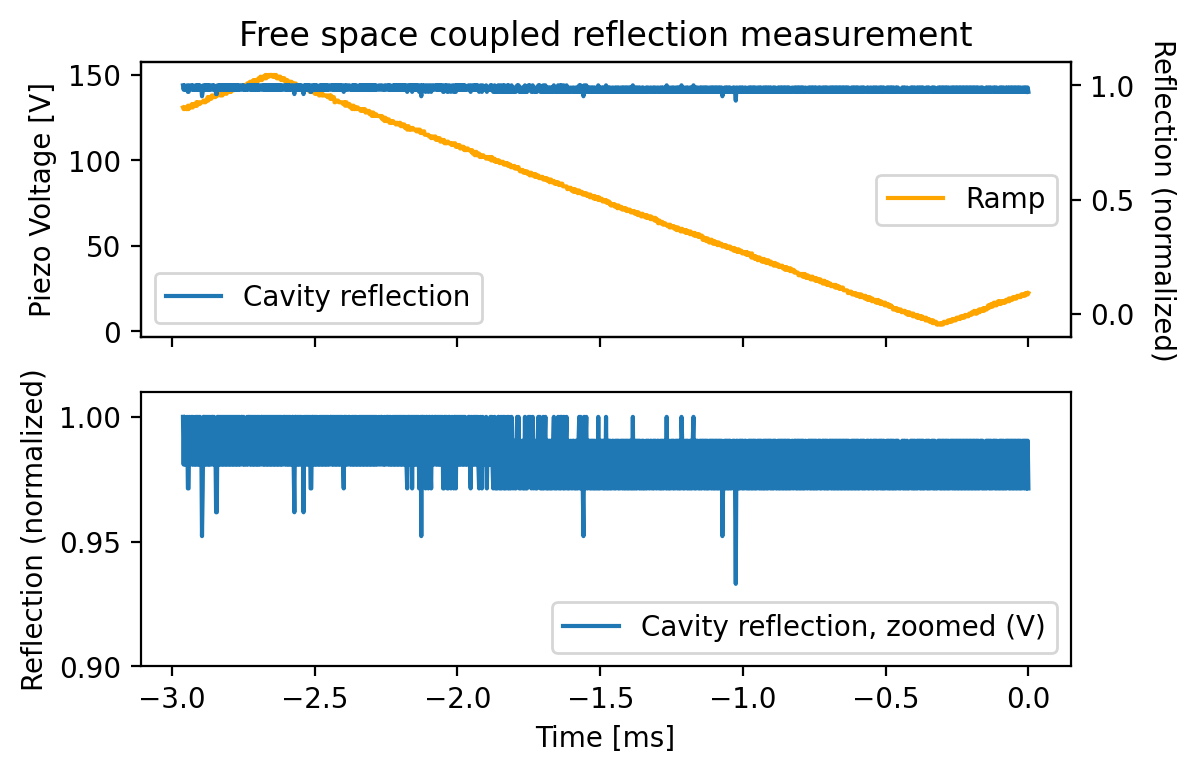

In [48]:
fig,axes = plt.subplots(2,1,sharex=True,dpi=200)
tpts = arange(0,len(data[0][1])*t_incr,t_incr)

ax,ax1 = axes

# zoomed out (in V) data
ax.set_title("Fiber cavity reflection measurement")
ax.plot(tpts,data[0][0],label='Ramp',c='orange')
ax.set_ylabel("Piezo Voltage [V]")
axy2 = ax.twinx()
norm_refl = data[0][1] - mean(data[1][1])
norm_refl /= max(norm_refl)
axy2.plot(tpts,norm_refl,label='Cavity reflection')
axy2.set_ylim((-0.1,1.1))
axy2.set_ylabel("Reflection (normalized)",rotation=-90)
axy2.yaxis.labelpad = 15
axy2.legend()
ax.legend(loc='right')

# zoomed in (in V) data
ax1.plot(tpts,norm_refl,label='Cavity reflection, zoomed (V)')
ax1.set_ylim((.9,1.01))
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel("Reflection (normalized)")
ax1.legend(loc='lower right')

# plt.savefig(fname,bbox_inches='tight')
plt.show()
# fname = 'ffpr_locked_vs_unlocked_20210607.png'

### 2021.10.19

In [88]:
# sample the file contents, get time increment

# data with modulated carrier for frequency reference
files = ['./20211019/'+f'ffpr_ramp_and_dips_eom{s}.csv' for s in ['']+list(range(1,5))]
fname = files[0]
newline=''
with open(fname, 'r', newline=newline) as f:
    reader = csv.reader(f, delimiter=',')
    for i,row in enumerate(reader):
        if i == 1:
            t_incr = float(row[2])        
        if i < 10:
            print(row)

['CH1', 'CH2', 'Start', 'Increment', '']
['Volt', 'Volt', '-6.00000e-05', '1.00000e-07']
['3.64e+01', '-8.00e-05', '']
['3.64e+01', '8.00e-05', '']
['3.64e+01', '0.00e+00', '']
['3.64e+01', '-8.00e-05', '']
['3.64e+01', '0.00e+00', '']
['3.64e+01', '8.00e-05', '']
['3.64e+01', '2.40e-04', '']
['3.64e+01', '8.00e-05', '']


In [83]:
data = [process_csv(f, skiprows=2) for f in files]
data

[array([[ 3.64e+01,  3.64e+01,  3.64e+01, ...,  4.00e+01,  4.00e+01,
          4.00e+01],
        [-8.00e-05,  8.00e-05,  0.00e+00, ...,  2.40e-04,  3.20e-04,
          1.60e-04]]),
 array([[ 3.64e+01,  3.64e+01,  3.64e+01, ...,  4.00e+01,  4.00e+01,
          4.00e+01],
        [ 8.00e-05,  2.40e-04,  8.00e-05, ...,  4.00e-04,  2.40e-04,
         -8.00e-05]]),
 array([[ 3.76e+01,  3.76e+01,  3.76e+01, ...,  4.12e+01,  4.16e+01,
          4.16e+01],
        [-1.60e-04,  8.00e-05,  3.20e-04, ...,  4.80e-04,  3.20e-04,
          2.40e-04]]),
 array([[ 3.64e+01,  3.64e+01,  3.64e+01, ...,  4.00e+01,  4.00e+01,
          4.00e+01],
        [-8.00e-05, -2.40e-04, -4.00e-04, ...,  2.40e-04,  3.20e-04,
          2.40e-04]]),
 array([[ 3.64e+01,  3.64e+01,  3.64e+01, ...,  4.00e+01,  4.00e+01,
          4.00e+01],
        [ 1.60e-04,  4.00e-04,  6.40e-04, ..., -8.00e-05,  2.40e-04,
         -8.00e-05]])]

In [95]:
# def get_linewidth(xpts, ypts, ystep=10):
#         """for xpts and ypts from a spectral trace with ypts in [dB],
#         return linewidth in kHz
        
#         ystep can be set to ensure the right-side 3dB point does not
#         fall on the left, adjacent to the left-side 3dB point by
#         accident. 
#         """
#         y0 = max(ypts)
#         # print(y0)
#         idxL = idxR = 0
#         for i in range(len(ypts)):
#             if ypts[i] > y0 - 3:
#                 idxL = i
#                 for j in range(idxL+ystep,len(ypts)):
#                     if ypts[j] < ypts[idxL]:
#                         idxR = j
#                         # print(f"xpts: {xpts[idxL]/1e6,xpts[idxR]/1e6}")
#                         # print(f"ypts: {ypts[idxL],ypts[idxR]}")
#                         break
#                 break
#         return (xpts[idxR] - xpts[idxL])/1e3
    
def norm_data(ypts, y0=0):
    """
    y0: if the 0 pt of the signal has a bias, set y0=bias
    """
    normed = ypts - y0
    normed /= max(normed)
    return normed

In [97]:
from scipy.optimize import curve_fit

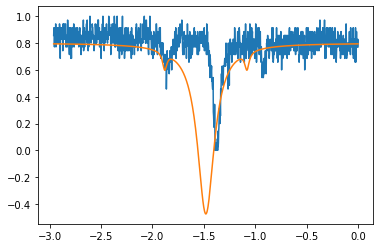

In [157]:
lor = lambda x,x0,g: ((1/pi)*(0.5*g))/((x-x0)**2+(0.5*g)**2)
def model(x,x0,fwhm1,fwhm2,a1,a2,omega,b):
    return (b-a2*lor(x,x0-omega,fwhm2) 
            -a2*lor(x,x0+omega,fwhm2) 
            -a1*lor(x,x0,fwhm1))
norm_d = norm_data(data[0][1],min(data[0][1]))
plt.plot(tpts,norm_d)
plt.plot(tpts,model(tpts,
                    x0=mean(tpts), # bounds [-2,1]
                    fwhm1=0.2, # bounds [0.01,.2]
                    fwhm2=0.05, # bounds [0.01,.2]
                    a1=0.4, # bounds [0.1,.4]
                    a2=0.01, # bounds [0.01,.05]
                    omega=.4,
                    b=0.8)) # bounds [0.7,1]
                

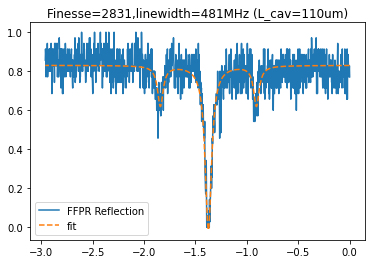

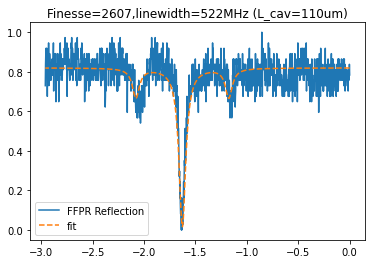

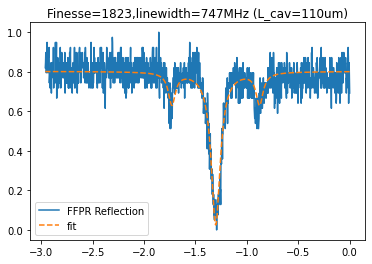

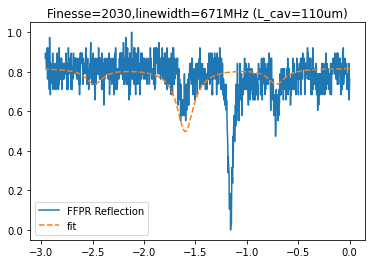

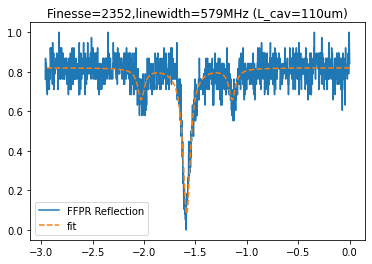

In [169]:
## fit to raw data

show_raw_data = True
show_smoothed_data = False

idx0 = 10
idx1 = -10 # clip the endpts of the convolution
tpts_smth = tpts[idx0:idx1]

# known cavity length
l_cav = 1.1e-4
FSR = c/(2*l_cav)

for d in data:
    fig,ax = plt.subplots()
    ksize = 10
    kernel = ones(ksize)/ksize
    norm_d = norm_data(d[1],min(d[1]))
    popt, pcov = curve_fit(model,tpts,norm_d,
                           bounds=([-4,0.01,0.01,0.1,0.01,0.4,0.7],
                                   [1,.2,.2,.4,.05,1,1]))
    x0,fwhm1,fwhm2,a1,a2,omega,b = popt
    
    # time to frequency conversion using known eom freq.
    Hz_per_t = 2.975e6/(omega/1e3)
    
    # FWHM of cavity at carrier linewidth in Hz
    fwhm_cav = Hz_per_t*fwhm1
    
    # Finesse
    F = FSR/fwhm_cav
    
#     print(f"Finesse={F},linewidth={fwhm_cav/1e6}MHz (L_cav=110um)")
    
    ax.set_title(f"Finesse={int(F)},linewidth={int(fwhm_cav/1e6)}MHz (L_cav=110um)")
    if show_raw_data:
        ax.plot(tpts,norm_d,label='FFPR Reflection')
    if show_smoothed_data:
        smoothed_data = convolve(norm_d,kernel,mode='same')[idx0:idx1]
        ax.plot(tpts_smth,smoothed_data,'-',label='smoothed data')
    ax.plot(tpts,model(tpts,*popt),'--',label='fit')
    ax.legend()

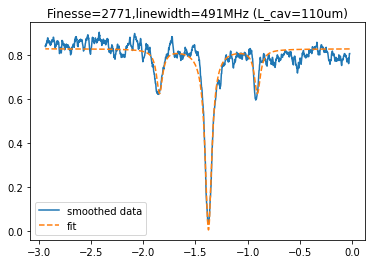

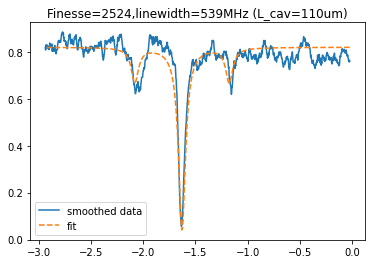

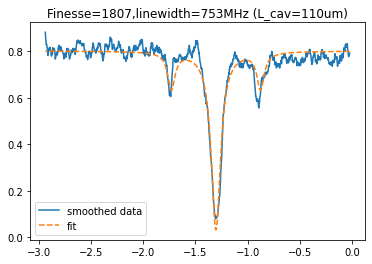

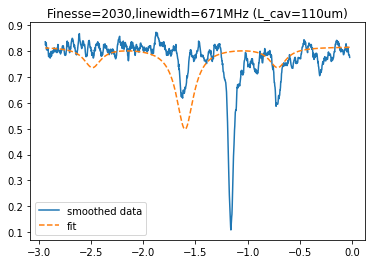

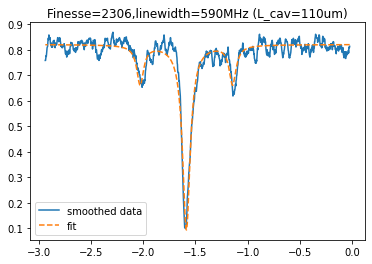

In [168]:
## fit to smoothed data

show_raw_data = False

idx0 = 10
idx1 = -10 # clip the endpts of the convolution
tpts_smth = tpts[idx0:idx1]

# known cavity length
l_cav = 1.1e-4
FSR = c/(2*l_cav)

for d in data:
    fig,ax = plt.subplots()
    ksize = 10
    kernel = ones(ksize)/ksize
    norm_d = norm_data(d[1],min(d[1]))
    smoothed_data = convolve(norm_d,kernel,mode='same')[idx0:idx1]
    popt, pcov = curve_fit(model,tpts_smth,smoothed_data,
                           bounds=([-4,0.01,0.01,0.1,0.01,0.4,0.7],
                                   [1,.2,.2,.4,.05,1,1]))
    x0,fwhm1,fwhm2,a1,a2,omega,b = popt
    
    # time to frequency conversion using known eom freq.
    Hz_per_t = 2.975e6/(omega/1e3)
    
    # FWHM of cavity at carrier linewidth in Hz
    fwhm_cav = Hz_per_t*fwhm1
    
    # Finesse
    F = FSR/fwhm_cav
    
#     print(f"Finesse={F},linewidth={fwhm_cav/1e6}MHz (L_cav=110um)")
    
    ax.set_title(f"Finesse={int(F)},linewidth={int(fwhm_cav/1e6)}MHz (L_cav=110um)")
    if show_raw_data:
        ax.plot(tpts,norm_d,label='FFPR Reflection')
    ax.plot(tpts_smth,smoothed_data,'-',label='smoothed data')
    ax.plot(tpts_smth,model(tpts_smth,*popt),'--',label='fit')
    ax.legend()

## Summer 2021

In [87]:
# sample the file contents, get time increment
files = ['ffpr_locked_20210607.csv','ffpr_unlocked_20210607.csv']
fname = files[0]
newline=''
with open(fname, 'r', newline=newline) as f:
    reader = csv.reader(f, delimiter=',')
    for i,row in enumerate(reader):
        if i == 1:
            t_incr = float(row[5])        
        if i < 10:
            print(row)

FileNotFoundError: [Errno 2] No such file or directory: 'ffpr_locked_20210607.csv'

In [83]:
data = [process_csv(f, skiprows=2) for f in files]
data

[array([[ 3.64e+01,  3.64e+01,  3.64e+01, ...,  4.00e+01,  4.00e+01,
          4.00e+01],
        [-8.00e-05,  8.00e-05,  0.00e+00, ...,  2.40e-04,  3.20e-04,
          1.60e-04]]),
 array([[ 3.64e+01,  3.64e+01,  3.64e+01, ...,  4.00e+01,  4.00e+01,
          4.00e+01],
        [ 8.00e-05,  2.40e-04,  8.00e-05, ...,  4.00e-04,  2.40e-04,
         -8.00e-05]]),
 array([[ 3.76e+01,  3.76e+01,  3.76e+01, ...,  4.12e+01,  4.16e+01,
          4.16e+01],
        [-1.60e-04,  8.00e-05,  3.20e-04, ...,  4.80e-04,  3.20e-04,
          2.40e-04]]),
 array([[ 3.64e+01,  3.64e+01,  3.64e+01, ...,  4.00e+01,  4.00e+01,
          4.00e+01],
        [-8.00e-05, -2.40e-04, -4.00e-04, ...,  2.40e-04,  3.20e-04,
          2.40e-04]]),
 array([[ 3.64e+01,  3.64e+01,  3.64e+01, ...,  4.00e+01,  4.00e+01,
          4.00e+01],
        [ 1.60e-04,  4.00e-04,  6.40e-04, ..., -8.00e-05,  2.40e-04,
         -8.00e-05]])]

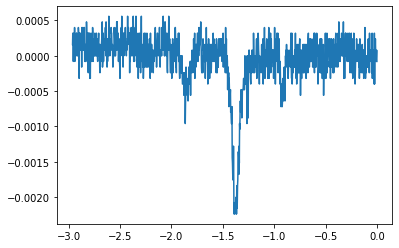

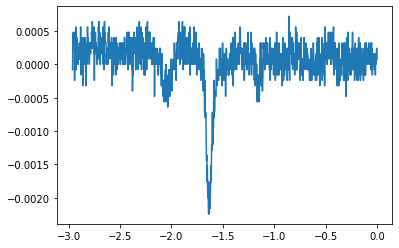

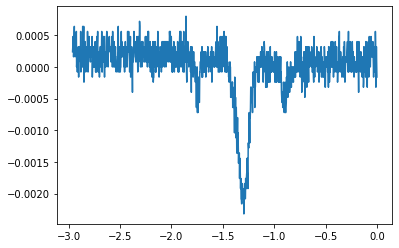

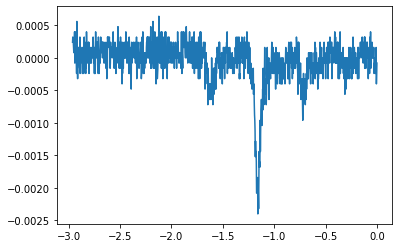

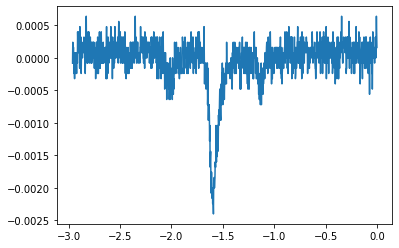

In [86]:
for d in data:
    fig,ax = plt.subplots()
    ax.plot(tpts,d[1],label='FFPR Reflection')

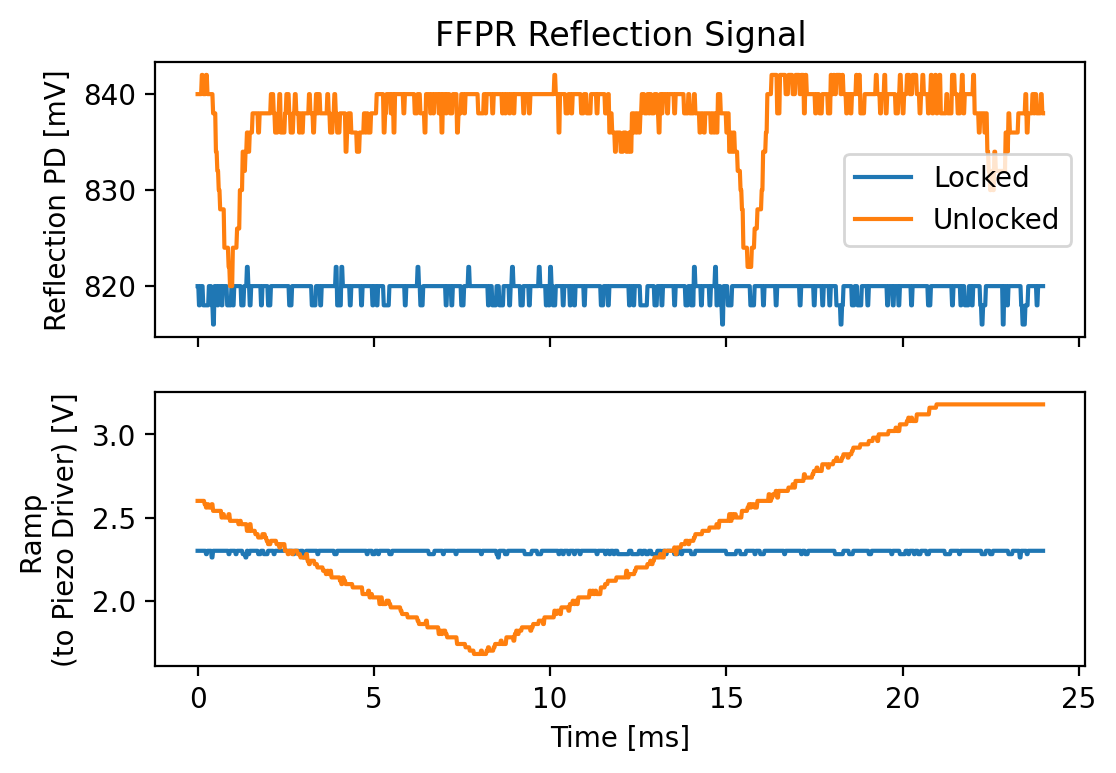

In [51]:
fig,axes = plt.subplots(2,1,sharex=True,dpi=200)
tpts = arange(0,len(data[0][1])*t_incr,t_incr)*1e3

ax,ax1 = axes

# locked data
ax.plot(tpts,data[0][2]*1e3,label='Locked')

# unlocked
ax.plot(tpts,data[1][2]*1e3,label='Unlocked')
ax.set_ylabel('Reflection PD [mV]')
ax.set_title('FFPR Reflection Signal')

ax1.plot(tpts,data[0][0],label='Ramp, locked')
ax1.plot(tpts,data[1][0],label='Ramp, unlocked')
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel("Ramp \n(to Piezo Driver) [V]")

ax.legend(loc='right')
plt.savefig(fname,bbox_inches='tight')
plt.show()
fname = 'ffpr_locked_vs_unlocked_20210607.png'